In [2]:
import xarray as xr
import glob
import os
from sublimpy import utils
import numpy as np 

In [3]:
filepath = "/Users/elischwat/Development/data/sublimationofsnow/sosqc/sos_qc_geo_tiltcor_v20240213/"
files = glob.glob(os.path.join(filepath, "*.nc"))

In [4]:
# sort files and remove datasets before November
files = sorted(files)[3:] # should be [3:]

# Create the hourly dataset

In [4]:
datasets = []
for fn in files:
    ds = xr.open_dataset(fn)
    datasets.append(ds)

In [ ]:
# THIS TAKES AN EXTREMELY LONG TIME TO RUN, ~8 Hours
# To make it run more quickly, just grab the variables you want
sos_ds = xr.concat(datasets, dim='time')

In [ ]:
sos_ds

In [ ]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [ ]:
sos_hourly_ds = sos_ds.resample(time='60Min').mean()

In [ ]:
sos_hourly_ds.to_netcdf('sos_hourly_ds.nc')

# Create the 5min dataset (include only eddy covariance latent heat flux measurements)

In [5]:
# datasets = []
# for fn in files:
#     ds = xr.open_dataset(fn)
#     vars_to_grab = []
#     if 'w_h2o__3m_c' in ds:
#         vars_to_grab.append('w_h2o__3m_c')
#     if 'w_h2o__5m_c' in ds:
#         vars_to_grab.append('w_h2o__5m_c')
#     if 'w_h2o__10m_c' in ds:
#         vars_to_grab.append('w_h2o__10m_c')
#     if 'w_h2o__15m_c' in ds:
#         vars_to_grab.append('w_h2o__15m_c')
#     if 'w_h2o__20m_c' in ds:
#         vars_to_grab.append('w_h2o__20m_c')

#     ds = ds[vars_to_grab]
#     datasets.append(ds)

all_vars_i_want = [
        'w_h2o__3m_c',
        'w_h2o__5m_c',
        'w_h2o__10m_c',
        'w_h2o__15m_c',
        'w_h2o__20m_c',

        'w_3m_c',
        'w_5m_c',
        'w_10m_c',
        'w_15m_c',
        'w_20m_c',

        'h2o_3m_c',
        'h2o_5m_c',
        'h2o_10m_c',
        'h2o_15m_c',
        'h2o_20m_c',
    ]

datasets = []
for fn in files:
    ds = xr.open_dataset(fn)
    vars_to_grab = []
    for var in all_vars_i_want:
        if var in ds:
            vars_to_grab.append(var)
    ds = ds[vars_to_grab]
    datasets.append(ds)

KeyboardInterrupt: 

In [ ]:
sos_ds = xr.concat(datasets, dim='time')

In [ ]:
sos_ds = utils.fill_missing_timestamps(sos_ds)

In [6]:
datasets[0]['h2o_3m_c']

<xarray.DataArray 'h2o_3m_c' (time: 288)>
[288 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2022-11-01T00:02:30 ... 2022-11-01T23:57:30
Attributes:
    long_name:   Water vapor density from CSI IRGA
    short_name:  h2o.3m.c
    units:       g/m^3
    counts:      counts_3m_c_1

Correctly aggregate latent heat flux covariances

In [7]:
sos_df = sos_ds.to_dataframe()

In [8]:
import pandas as pd

In [9]:
sos_df.head()

,w_h2o__3m_c,w_h2o__5m_c,w_h2o__10m_c,w_h2o__15m_c,w_h2o__20m_c,w_3m_c,w_5m_c,w_10m_c,w_15m_c,w_20m_c,h2o_3m_c,h2o_5m_c,h2o_10m_c,h2o_15m_c,h2o_20m_c
time,,,,,,,,,,,,,,,
2022-11-01 00:02:30,0.002551,0.002108,-0.001720,-0.001724,-0.001655,0.004164,0.010368,-0.009353,0.016994,-0.065659,2.592946,4.068023,2.696079,3.546998,2.091119
2022-11-01 00:07:30,0.002685,0.002533,0.000644,0.000790,-0.000557,-0.004525,-0.016842,-0.064504,-0.053707,-0.147982,2.561579,4.011229,2.686768,3.556582,2.133711
2022-11-01 00:12:30,0.002699,0.001475,0.000226,-0.000175,-0.001423,-0.004106,0.009653,-0.002897,0.010658,-0.030326,2.565340,4.010930,2.757975,3.617332,2.205462
2022-11-01 00:17:30,0.002083,0.001097,0.001264,-0.000599,0.000129,0.009622,0.015220,-0.032097,-0.029827,-0.126656,2.532390,3.973908,2.732438,3.603410,2.193537
2022-11-01 00:22:30,0.002863,0.002551,0.005189,0.005257,0.005036,-0.022954,-0.047121,-0.151870,-0.186969,-0.320205,2.519458,3.959042,2.734835,3.599319,2.175920


In [10]:
covariance_variable_sets = [
    ('w_h2o__3m_c', 'w_3m_c', 'h2o_3m_c'),
    ('w_h2o__5m_c', 'w_5m_c', 'h2o_5m_c'),
    ('w_h2o__10m_c', 'w_10m_c', 'h2o_10m_c'),
    ('w_h2o__15m_c', 'w_15m_c', 'h2o_15m_c'),
    ('w_h2o__20m_c', 'w_20m_c', 'h2o_20m_c'),   
]
agg_df_list = []
for cov, w, h2o in covariance_variable_sets:
    agg_df = pd.DataFrame({
        cov: sos_df.groupby(pd.Grouper(freq='60Min')).apply(
            lambda row: 
                (1/12)*(row[cov] + row[w]*row[h2o]).sum()
                - (
                    (1/12)*row[w].sum()
                    * (1/12)*row[h2o].sum()
                )
        )
    })
    agg_df_list.append(agg_df)

In [11]:
combined_agg_df = agg_df_list[0]
for i in range(1, len(agg_df_list)):
    combined_agg_df = combined_agg_df.join(agg_df_list[i])

In [12]:
combined_agg_df

,w_h2o__3m_c,w_h2o__5m_c,w_h2o__10m_c,w_h2o__15m_c,w_h2o__20m_c
time,,,,,
2022-11-01 00:00:00,0.003044,0.001990,0.002903,0.002291,0.003268
2022-11-01 01:00:00,0.002005,0.001179,0.001240,0.000282,-0.000468
2022-11-01 02:00:00,-0.000033,0.000965,-0.000666,0.000399,0.001218
2022-11-01 03:00:00,-0.000047,-0.000040,-0.000630,-0.000286,-0.001603
2022-11-01 04:00:00,-0.000210,-0.000376,-0.000914,0.000030,0.000860
...,...,...,...,...,...
2023-06-19 19:00:00,0.149408,0.149686,0.154477,0.094259,0.104221
2023-06-19 20:00:00,0.170098,0.174629,0.195074,0.097739,0.132808
2023-06-19 21:00:00,0.148896,0.146460,0.173781,0.097515,0.121248


In [13]:
wrong_combined_agg_df = sos_df[[
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
]].groupby(pd.Grouper(freq='60Min')).mean()

In [14]:
wrong_combined_agg_df.loc['20221221': '20221224'].reset_index().melt(id_vars='time')

,time,variable,value
0,2022-12-21 00:00:00,w_h2o__3m_c,0.000846
1,2022-12-21 01:00:00,w_h2o__3m_c,0.000303
2,2022-12-21 02:00:00,w_h2o__3m_c,-0.000136
3,2022-12-21 03:00:00,w_h2o__3m_c,-0.013690
4,2022-12-21 04:00:00,w_h2o__3m_c,0.000000
...,...,...,...
475,2022-12-24 19:00:00,w_h2o__20m_c,0.005898
476,2022-12-24 20:00:00,w_h2o__20m_c,0.006391
477,2022-12-24 21:00:00,w_h2o__20m_c,0.001543
478,2022-12-24 22:00:00,w_h2o__20m_c,0.001376


In [15]:
import altair as alt
(
    alt.Chart(
        wrong_combined_agg_df.loc['20221221': '20221224'].reset_index().melt(id_vars='time')
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q").title('Latent heat flux (g/m^2/s)'),
        alt.Color("variable:O").scale(scheme='rainbow', domain=[
                'w_h2o__3m_c',
                'w_h2o__5m_c',
                'w_h2o__10m_c',
                'w_h2o__15m_c',
                'w_h2o__20m_c',
        ])
    ).properties(title = 'Incorrect covariance averages') | alt.Chart(
        combined_agg_df.loc['20221221': '20221224'].reset_index().melt(id_vars='time')
    ).mark_line().encode(
        alt.X("time:T"),
        alt.Y("value:Q").title('Latent heat flux (g/m^2/s)'),
        alt.Color("variable:O").scale(scheme='rainbow', domain=[
                'w_h2o__3m_c',
                'w_h2o__5m_c',
                'w_h2o__10m_c',
                'w_h2o__15m_c',
                'w_h2o__20m_c',
        ])
    ).properties(title = 'Correct covariance averages')
).resolve_scale(x='shared', y='shared', color='shared').display(renderer='svg')

alt.HConcatChart(...)

Test with a single variable using simpler code

In [16]:
new_values = []
for i in range(0, int(len(sos_ds.time)/12)):
    start_i = i*12
    end_i = (i+1)*12
    cov_values = sos_ds['w_h2o__3m_c'][start_i: end_i].values
    w_values = sos_ds['w_3m_c'][start_i: end_i].values
    h2o_values = sos_ds['h2o_3m_c'][start_i: end_i].values
    new_val  = (
        (1/12)*(cov_values + w_values*h2o_values).sum() 
        - (
            (1/12)*w_values.sum()
            * (1/12)*h2o_values.sum()
        )
    )
    new_values.append(new_val)

In [17]:
np.unique(combined_agg_df['w_h2o__3m_c'].values - np.array(new_values))

array([ 0., nan])

# Save 60 min lh flux values

In [18]:
combined_agg_df.to_xarray().to_netcdf('sos_hourly_aggregated_lhflux_ds.nc')

# Check that the cumulative sublimation measurements look right.

In [19]:
from metpy.constants import density_water

In [20]:
sos_ds_mm = sos_ds*5*60/density_water.magnitude

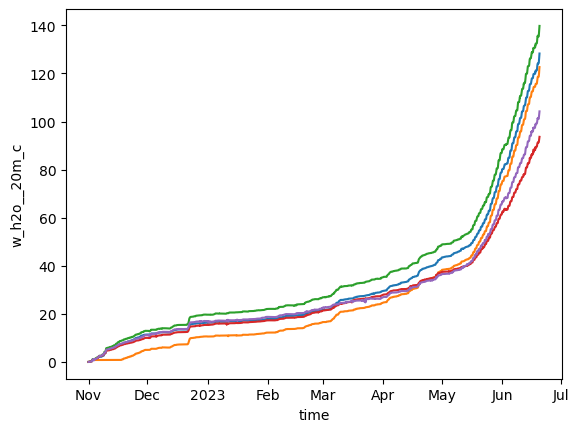

In [21]:
sos_ds_mm['w_h2o__3m_c'].cumsum().plot()
sos_ds_mm['w_h2o__5m_c'].cumsum().plot()
sos_ds_mm['w_h2o__10m_c'].cumsum().plot()
sos_ds_mm['w_h2o__15m_c'].cumsum().plot()
sos_ds_mm['w_h2o__20m_c'].cumsum().plot()